In [1]:
import pandas as pd
pd.options.display.max_colwidth = 4000
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import skfuzzy as fuzz
import pickle
import seaborn as sns
import random
import itertools
import re
from collections import Counter
from wordcloud import WordCloud
import scipy.stats as stats
from scipy.stats import norm

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import gensim.downloader

import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.layers import Embedding, Reshape, GlobalMaxPooling1D, Bidirectional, Dropout, Lambda
from tensorflow.keras.layers import LSTM, Dense, Flatten, Activation, RepeatVector, Permute, Multiply
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LambdaCallback

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

/var/folders/y3/qz4wgjts6dj2m3kdg2nq67200000gn/T/ipykernel_23400/3718752021.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chufeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/chufeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/chufeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/chuf

In [2]:
# Preprocessing
def basic_processing(df):
    words_to_remove = ["e.g.", "code", "may", "attack", "system", "adversary", "Adversaries"]
    for word in words_to_remove:
        df['NameDesc'] = df['NameDesc'].apply(lambda x: x.replace(word, ''))
    for word in words_to_remove:
        df['NameDesc'] = df['NameDesc'].apply(lambda x: re.sub(r'\b' + re.escape(word) + r'\b', '', x))

    # df['NameDesc'] = df['NameDesc'].str.replace(r"\b(" + "|".join(words_to_remove) + r")\b", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("<br><br>", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("\(Citation:.*?\)", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("http\S+", "", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("  +", " ", regex=True)
    df['NameDesc'] = df['NameDesc'].str.replace("[^A-Za-z]", " ", regex=True)
    return df

def rm_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['NameDesc'] = df['NameDesc'].apply(lambda x: [word for word in x if word not in stop_words])
    # print(f"Removed stopwords:\n {df.head(3).NameDesc}\n")
    return df

def lemmatize(df):
    lemmatizer = WordNetLemmatizer()
    def lemmatize_tokens(tokens):
        def get_wordnet_pos(word):
            tag = nltk.pos_tag([word])[0][1][0].upper()
            tag_dict = {"J": wordnet.ADJ,
                        "N": wordnet.NOUN,
                        "V": wordnet.VERB,
                        "R": wordnet.ADV}
            return tag_dict.get(tag, wordnet.NOUN)
        lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
        return lemmas
    df['NameDesc'] = df['NameDesc'].apply(lambda x: lemmatize_tokens(x))
    # print(f"Lemmatized words:\n {df.head(3).NameDesc}")
    return df

def text_preprocessing(df):
    basic_processing(df)
    df['NameDesc'] = df['NameDesc'].apply(lambda x: word_tokenize(x))
    rm_stopwords(df)
    lemmatize(df)

    k = random.randint(0, len(df)) # arbitary row to show that words have been removed
    print(f"Bef rm duplicates: {len(df.iloc[k]['NameDesc'])}")
    df['NameDesc'] = df['NameDesc'].apply(lambda x: list(set([word.lower() for word in x]))) # to remove duplicates
    print(f"Aft rm duplicates: {len(df.iloc[k]['NameDesc'])}")
    print(f"Removed duplicates:\n {df.head(3).NameDesc}")

    print("=========================================")
    return df

<h3>Fuzzy clustering<h3>

In [ ]:
df = pd.read_excel('data/raw_capec_data.xlsx', sheet_name="Threats")
df["NameDesc"] = df["Name"] + " " + df["Desc"]
df['NameDesc'] = df['NameDesc'].astype(str)

corpus = df['NameDesc']

with open('model/vectorizer.pickle', 'rb') as fin:
    tfidf = pickle.load(fin)

X = tfidf.transform(corpus).toarray()

n_clusters = 6

# Fuzzy C-Means algorithm
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X.T, n_clusters, m=2, error=0.005, maxiter=1000
)

cluster_membership = np.argmax(u, axis=0)

df['Cluster'] = cluster_membership
df['STRIDE'] = df[['S', 'T', 'R', 'I', 'D', 'E']].astype(str).agg(''.join, axis=1)

print(df[['STRIDE', 'Cluster']].head(3))

In [ ]:
stride_counts_per_cluster = df.groupby('Cluster')['STRIDE'].nunique()
    
for cluster, group in df.groupby('Cluster'):
    unique_values = group['STRIDE'].unique()
    print(f"Cluster {cluster} - Unique STRIDE Values: {unique_values}")

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    plt.hist(u[i], bins=20, alpha=0.5, label=f'Cluster {i}')

plt.title('Fuzzy C-Means Membership Distribution')
plt.xlabel('Membership Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<h3>Extracting more keywords<h3>

In [3]:
df = pd.read_excel('data/mitre-classified.xlsx')

def change_label(df):
    stride_mapping = { # STRIDE
        1: 1, # E
        10: 2, # D
        100: 3, # I
        1000: 4, # R
        10000: 5, # T
        100000: 0, # S
        11000: 4,
        100100: 0
    }
    df['STRIDE'] = df['STRIDE'].map(stride_mapping)

while True:
    df_train, temp = train_test_split(df, test_size=0.3)
    df_test, df_dev = train_test_split(temp, test_size=1/3)

    change_label(df_train)
    change_label(df_test)
    change_label(df_dev)

    c = set([0, 1, 2, 3, 4, 5])
    if set(df_train['STRIDE'].unique()) != c or \
        set(df_test['STRIDE'].unique()) != c or \
        set(df_dev['STRIDE'].unique()) != c:
            continue
    else:
        break
    
col_toDrop = ['Ref', 'Name', 'Desc', 'Confidentiality', 'Integrity', 'Availability', 'Ease Of Exploitation', 'References', 'Unnamed: 0']
df_train = df_train.reset_index(drop=True).drop(columns=col_toDrop)
df_test = df_test.reset_index(drop=True).drop(columns=col_toDrop)
df_dev = df_dev.reset_index(drop=True).drop(columns=col_toDrop)

display(df_train.head(1))
print(f"df_train:\n{df_train['STRIDE'].value_counts()}\n")
print(f"df_dev:\n{df_dev['STRIDE'].value_counts()}\n")
print(f"df_test:\n{df_test['STRIDE'].value_counts()}")
# print((df_train.iloc[0]['NameDesc']))

,NameDesc,STRIDE
0,"Rename System Utilities Adversaries may rename legitimate system utilities to try to evade security mechanisms concerning the usage of those utilities. Security monitoring and control mechanisms may be in place for system utilities adversaries are capable of abusing. (Citation: LOLBAS Main Site) It may be possible to bypass those security mechanisms by renaming the utility prior to utilization (ex: rename <code>rundll32.exe</code>). (Citation: Elastic Masquerade Ball) An alternative case occurs when a legitimate utility is copied or moved to a different directory and renamed to avoid detections based on system utilities executing from non-standard paths. (Citation: F-Secure CozyDuke)<br><br>If file names are mismatched between the file name on disk and that of the binary's PE metadata, this is a likely indicator that a binary was renamed after it was compiled. Collecting and comparing disk and resource filenames for binaries by looking to see if the InternalName, OriginalFilename, and/or ProductName match what is expected could provide useful leads, but may not always be indicative of malicious activity. (Citation: Elastic Masquerade Ball) Do not focus on the possible names a file could have, but instead on the command-line arguments that are known to be used and are distinct because it will have a better rate of detection.(Citation: Twitter ItsReallyNick Masquerading Update)",5


df_train:
STRIDE
1    161
3    104
5     41
0     25
2      7
4      1
Name: count, dtype: int64

df_dev:
STRIDE
1    20
3    16
5     9
0     2
4     1
2     1
Name: count, dtype: int64

df_test:
STRIDE
1    35
3    33
5    16
0     7
4     3
2     3
Name: count, dtype: int64


In [5]:
text_preprocessing(df_train)
text_preprocessing(df_test)
text_preprocessing(df_dev)

Bef rm duplicates: 59
Aft rm duplicates: 43
Removed duplicates:
 0    [activity, execute, expect, know, bypass, legitimate, likely, pe, avoid, lead, directory, look, instead, evade, distinct, system, path, provide, productname, if, exe, mechanism, rate, always, detection, utilities, standard, argument, compile, malicious, indicative, different, disk, prior, compare, useful, resource, case, possible, filename, originalfilename, concern, file, focus, adversary, occurs, rename, indicator, command, metadata, monitoring, mismatch, well, try, do, an, control, use, collecting, copy, non, ex, abuse, could, name, capable, utilization, internalname, match, move, place, binary, security, usage, see, rundll, base, it, alternative, line, utility]
1                                                                                                                                             [search, group, key, follow, exploitation, window, password, preference, unsecured, controller, script, gather, al

,NameDesc,STRIDE
0,"[members, activity, group, abuse, password, unscheduled, controller, windows, api, admins, current, call, able, change, create, application, mimikatz, know, the, originate, run, replication, computer, access, ips, legacy, protocol, dcsync, include, technique, directory, sensitive, netsync, attempt, performs, credential, krbtgt, network, potentially, default, enterprise, remote, lsadump, ticket, golden, data, hash, interface, program, process, active, log, associate, also, module, possibly, historical, admin, request, information, domain, use, simulate, pull, useful, pass, note, monitor, turn, manipulation, functionality, administrators, account]",1
1,"[a, signature, activity, decompress, change, software, call, know, create, file, list, most, run, memory, original, method, protection, example, legitimate, size, proprietary, packer, detection, utilities, compress, avoid, translates, technique, adversary, defense, protect, perform, machine, binary, attempt, indicator, look, special, encrypt, malicious, mpress, pack, evade, decompression, conceal, virtual, upx, leave, well, format, base, executable, comprehensive, artifact, use, definitive, packing, scan, reduce, available]",5
2,"[activity, suspicious, credentials, infrastructure, iaas, api, without, cloud, allows, legitimate, gcp, service, persistent, interface, generate, az, root, additional, importkeypair, key, unexpected, way, within, accounts, azure, powershell, either, o, addition, also, module, environment, monitor, particularly, import, modification, password, portal, ad, create, application, sufficient, victim, with, correlate, createkeypair, adversary, x, instance, credential, command, these, compute, principals, logs, control, use, gcloud, ssh, aws, apis, access, time, include, gain, permission, add, login, user, usage, principal, maintain, applications, in, exist, line, variety, unusual, compromise, this, account]",1
3,"[event, activity, search, suspicious, design, credentials, unlocks, password, exploitation, could, obtain, api, master, call, know, application, file, memory, manager, access, text, guessing, unlocked, indicate, database, surround, after, acquire, credential, normally, encrypt, these, party, user, monitoring, force, accessible, try, third, managers, store, consider, process, also, via, plain, disk, read, brute, provide, extract, copy, typically]",1
4,"[credentials, windows, know, vista, style, occur, recover, attempt, number, valid, instead, remote, newer, system, v, domain, invoke, operating, derive, functionality, like, version, additional, event, reg, pbkdf, controller, pas, alter, mimikatz, feature, accounts, detection, powershell, analysis, argument, built, unavailable, collect, dcc, indicative, program, format, also, module, configure, monitor, extract, password, allow, per, help, with, authentication, on, execution, adversary, plaintext, credential, command, contain, cached, varies, well, necessary, log, information, use, note, py, script, the, tool, access, ms, require, dump, default, powersploit, secretsdump, hash, process, exist, line, utility, compromise, incorporate, cache, this, cracking]",5
5,"[dns, ip, rely, calculation, a, octet, filter, one, bypass, know, rather, specific, record, return, traffic, detection, analyze, address, port, actual, implementation, take, technique, perform, number, result, calculate, channel, require, command, difficult, algorithm, determine, value, c, control, first, use, would, egress, response, knowledge, predetermine, three, possible]",3
6,"[often, follow, behavior, high, list, as, programmatic, repository, directory, closely, number, procedure, valuable, system, found, technical, policies, domain, functionality, development, behavioral, hold, work, if, physical, architecture, project, within, report, learn, page, detection, alert, certain, standard, links, malicious, network, detect, indicative, logical, at, active, also, environment, documentation, retrieve, useful, configure, monitor, 

#### STRIDE MAPPING:
S  T  R  I  D  E \
0  5  4  3  2  1

<h3>Manually filter out words<h3>

In [63]:
# predefined keywords for each STRIDE category

S = ['authenticate', 'username', 'password', 'access'] #add more words
T = ['modify', 'persistent', 'database', 'alter', 'open', 'network', 'internet'] #add more words
R = ['deny', 'action', 'prove', 'non-repudiation', 'item', 'sign', 'receipt', 'receive', 'evidence', 'package', 'untrace',]
I = ['exposure', 'individual', 'access', 'file', 'granted', 'intruder', 'transit']
D = ['denial', 'service', 'dos', 'web', 'server', 'unavailable', 'unusable', 'system', 'available', 'reliable']
E = ['unprivileged', 'privileged', 'access', 'compromise', 'entire', 'system', 'elevation', 'penetrate', 'defenses', 'untrusted', 'trusted']

In [ ]:
def word_occurrence_by_group(df):
    token_counts_by_group = {}
    grouped_df = df.groupby('STRIDE')
    for stride_value, group_df in grouped_df:
        all_tokens = []
        for tokens in group_df['NameDesc']:
            all_tokens.extend(tokens)
        token_count = Counter(all_tokens)
        token_counts_by_group[stride_value] = token_count
    return token_counts_by_group

token_counts_by_group = word_occurrence_by_group(df_train)
keyw = {}
for s, tkcounts in token_counts_by_group.items():
    for key, num in tkcounts.items():
        keyw.setdefault(s, []).append(key)
keyw

In [ ]:
def word_occurrence_by_group(df):
    token_counts_by_group = {}
    grouped_df = df.groupby('STRIDE')
    for stride_value, group_df in grouped_df:
        all_tokens = []
        for tokens in group_df['NameDesc']:
            all_tokens.extend(tokens)
        token_count = Counter(all_tokens)
        token_counts_by_group[stride_value] = token_count
    return token_counts_by_group

# prob distribution for word occurrence of entire corpus
def plot_normal_dist(token_counts_by_group):
    for stride_value, token_count in token_counts_by_group.items():
        mu = np.mean(list(token_count.values()))
        sigma = np.std(list(token_count.values()))
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        plt.plot(x, stats.norm.pdf(x, mu, sigma), label=f'STRIDE {stride_value}')

    plt.title('Normal Probability Distribution for Word Occurrences')
    plt.xlabel('Word Occurrences')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

# Assuming df_train is your DataFrame
token_counts_by_group = word_occurrence_by_group(df_train)
plot_normal_dist(token_counts_by_group)

In [64]:
# words to keep (manual)
S_keep = ['information', 'detection', 'take',  'include', 'malicious', 'control', 'network', 'search', 'name', 'access', 'infrastructure', 'traffic', 'data', 'suspicious', 'trust', 'reconnaissance', 'email', 'phishing', 'resource', 'initial', 'visibility', 'monitor', 'server', 'form', 'open', 'potentially', 'websites', 'address', 'process', 'detect', 'credential', 'file', 'certificate', 'internet', 'install', 'key', 'online', 'link', 'source']
E_keep = ['process', 'access', 'file', 'execute', 'activity', 'execution', 'network', 'behavior', 'create', 'control', 'log', 'privilege', 'application', 'service', 'within', 'event', 'account', 'modify', 'run', 'abuse', 'monitoring', 'environment', 'binary', 'credential', 'enable', 'api', 'exe', 'function', 'payload', 'target', 'method', 'services', 'launch', 'root', 'os', 'many''accounts']
D_keep = ['service', 'target', 'tool', 'command', 'cause', 'server', 'network', 'outside', 'denial', 'dos', 'availability', 'high', 'destruction', 'infrastructure']
I_keep = ['data', 'network', 'activity', 'access', 'behavior', 'environment', 'process', 'detection', 'remote', 'base', 'target', 'tool', 'file', 'api', 'traffic', 'acquire', 'application', 'host', 'infrastructure', 'device']
R_keep = ['user', 'application', 'api', 'activity', 'audit', 'source', 'system', 'native', 'hide', 'error', 'intrusion', 'function', 'record', 'clear', 'gcp', 'permission', 'analysis', 'collection', 'updatesink', 'indicate', 'detection', 'data', 'collect', 'environment', 'call', 'limit', 'cloudtrail', 'loss', 'conduct', 'prior', 'delete', 'cloud', 'configservicev', 'cloudwatch', 'diagnostic', 'capability', 'sufficient', 'insight', 'avoid']
T_keep = ['malicious', 'file', 'activity', 'process', 'execute', 'access', 'information', 'control', 'software', 'modify', 'network', 'data', 'abuse', 'exe', 'manipulate', 'bypass', 'malware', 'functionality', 'integrity', 'dll', 'anomaly', 'install']

In [65]:
# combine both lists together by group
S_final = S + S_keep
T_final = T + T_keep
R_final = R + R_keep
I_final = I + I_keep
D_final = D + D_keep
E_final = E + E_keep

In [8]:
w2v = gensim.downloader.load('word2vec-google-news-300')

In [66]:
stride_sets = {0: set(), 1: set(), 2: set(), 3: set(), 4: set(), 5: set()}

for index, row in df_train.iterrows():
    stride_value = row['STRIDE']
    if stride_value in stride_sets:
        name_desc_list = row['NameDesc']
        stride_sets[stride_value].update(name_desc_list)

stride_lists = {stride_value: list(words) for stride_value, words in stride_sets.items()}

def average_cosine_similarity(list1, list2, model):
    list1_vectors = [model.get_vector(word) for word in list1 if word in model.key_to_index]
    list2_vectors = [model.get_vector(word) for word in list2 if word in model.key_to_index]
    
    if not list1_vectors or not list2_vectors:
        return None
    
    cosine_sim_matrix = np.dot(list1_vectors, np.transpose(list2_vectors))
    average_cosine_sim = np.mean(cosine_sim_matrix)
    return average_cosine_sim

avg_cosine_sim = average_cosine_similarity(df_train.loc[0, 'NameDesc'], S_final, w2v)
print("Average Cosine Similarity:", avg_cosine_sim)

Average Cosine Similarity: 0.9630323


In [67]:
def merge_lists(l1, min_cosine_value, w2v, ref_list):
    final_list = []
    
    for word in l1:
        if word in w2v:
            similarities = []
            for ref_word in ref_list:
                if ref_word in w2v:
                    sim = w2v.similarity(word, ref_word)
                    similarities.append(sim)
            if any(sim >= min_cosine_value for sim in similarities):
                final_list.append(word)
    if 'use' in final_list: final_list.remove('use')
    elif 'also' in final_list: final_list.remove('also')
    return final_list


min_cosine_value = 0.28
# list1 = ['apples', 'oranges', 'samsung', 'today']
# reference_words = I_final

# merged_list = merge_lists(list1, min_cosine_value, w2v, reference_words)
# print(f"Resultant merged list: {merged_list}")
# print(f"Words removed: {set(I_final) - set(merged_list)}")

In [68]:
for i in range(len(df_train)):
    if df_train.iloc[i]['STRIDE'] == 0:
        updated_list = merge_lists(df_train.loc[i, 'NameDesc'], min_cosine_value, w2v, S_final)
    elif df_train.iloc[i]['STRIDE'] == 1:
        updated_list = merge_lists(df_train.loc[i, 'NameDesc'], min_cosine_value, w2v, E_final)
    elif df_train.iloc[i]['STRIDE'] == 2:
        updated_list = merge_lists(df_train.loc[i, 'NameDesc'], min_cosine_value, w2v, D_final)
    elif df_train.iloc[i]['STRIDE'] == 3:
        updated_list = merge_lists(df_train.loc[i, 'NameDesc'], min_cosine_value, w2v, I_final)
    elif df_train.iloc[i]['STRIDE'] == 4:
        updated_list = merge_lists(df_train.loc[i, 'NameDesc'], min_cosine_value, w2v, R_final)
    else:
        updated_list = merge_lists(df_train.loc[i, 'NameDesc'], min_cosine_value, w2v, T_final)
    
    df_train.at[i, 'NameDesc'] = updated_list

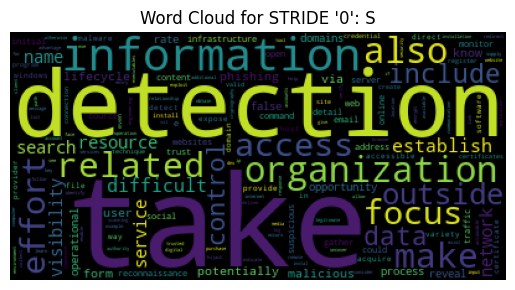

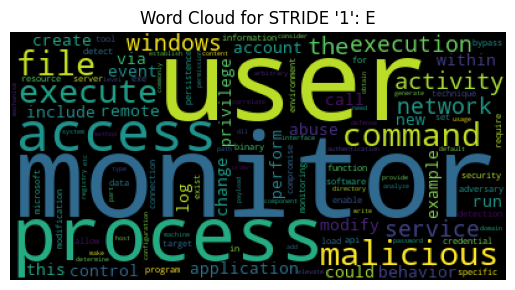

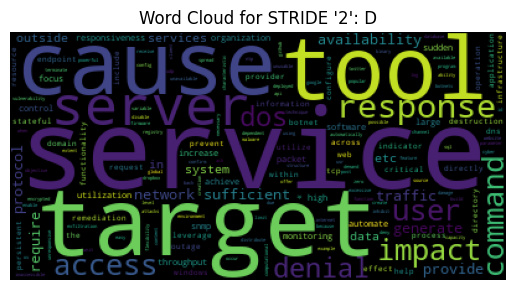

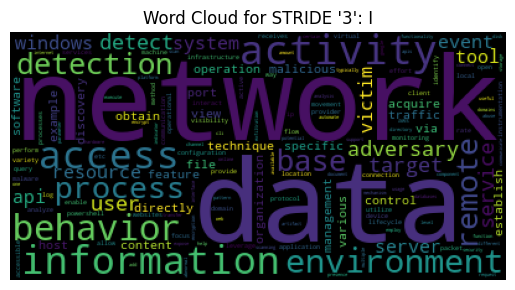

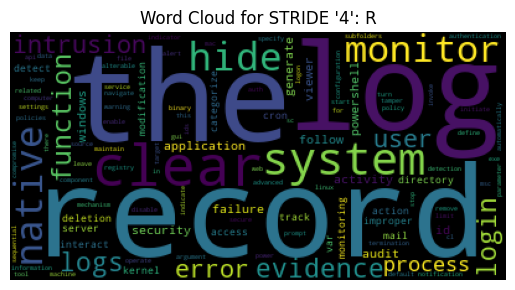

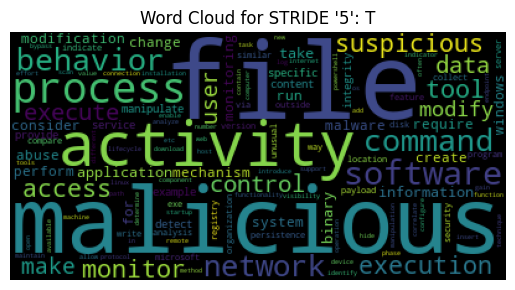

In [69]:
# Visualise word frequencies using word cloud
def word_occurrence_by_group(df):
    token_counts_by_group = {}
    grouped_df = df.groupby('STRIDE')
    for stride_value, group_df in grouped_df:
        all_tokens = []
        for tokens in group_df['NameDesc']:
            all_tokens.extend(tokens)
        token_count = Counter(all_tokens)
        token_counts_by_group[stride_value] = token_count
    return token_counts_by_group

token_counts_by_group = word_occurrence_by_group(df_train)
for stride_value, token_count in token_counts_by_group.items():
    wordcloud = WordCloud(background_color="black").generate_from_frequencies(token_count)
    plt.imshow(wordcloud)
    plt.axis("off")
    sv = ['S','E','D','I','R','T']
    plt.title(f"Word Cloud for STRIDE '{stride_value}': {sv[stride_value]}")
    plt.show()

In [70]:
tfidf_vectorizer = TfidfVectorizer()

df_train['NameDesc'] = df_train['NameDesc'].apply(lambda x: ' '.join(x))
df_test['NameDesc'] = df_test['NameDesc'].apply(lambda x: ' '.join(x))
df_dev['NameDesc'] = df_dev['NameDesc'].apply(lambda x: ' '.join(x))

X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['NameDesc']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(df_test['NameDesc']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(df_dev['NameDesc']).toarray()

y_train = df_train['STRIDE'].values
y_test = df_test['STRIDE'].values
y_val = df_dev['STRIDE'].values

In [ ]:
# hyperparameter tuning
num_epochs = 50
num_classes = 6
vocab_size = X_train_tfidf.shape[1]
dropout_rates = [0.2, 0.3, 0.4, 0.5]
activations_list = ['relu', 'leaky_relu', 'elu', 'tanh']
num_neurons = [32, 64, 128, 256]
opt_lr = [1e-2, 1e-3, 1e-4]
L2_lr = [1e-2, 1e-3, 1e-4]
best_params = None
best_val_acc = 0

hyperparam_combi = itertools.product(dropout_rates, num_neurons, activations_list, opt_lr, L2_lr)

for dr, nn, al, olr, l2lr in tqdm.tqdm(hyperparam_combi):
    modelTest = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(vocab_size,)),
    tf.keras.layers.Dense(nn*2, activation=al),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(nn, activation=al),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(nn//2, activation=al),
    tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2), activation='softmax')
    ])

    optimizer = tf.keras.optimizers.legacy.Adam(olr)
    modelTest.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=0,
        restore_best_weights=True
    )
    histTest = modelTest.fit(
        X_train_tfidf, y_train,
        batch_size=16,
        epochs=num_epochs,
        validation_data=(X_val_tfidf, y_val),
        verbose=0,
        callbacks=[early_stop,]
    )

    val_acc = max(histTest.history['val_accuracy'])
    # print(f"Dropout: {dr}, Activation: {al}, Hidden Units: {nn}, L2 Reg: {l2lr}, LR: {olr}, Best Val Acc: {val_acc}\n===========================")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = (dr, nn, al, olr, l2lr)
print(f"Final Best Hyperparameters: Dropout: {best_params[0]},\nActivation: {best_params[2]},\nHidden Units: {best_params[1]},\nL2 Reg: {best_params[4]},\nLR: {best_params[3]},\nBest Val Acc: {best_val_acc}")


In [71]:
# model
hidden_units = 128
batch_size = 16
num_epochs = 50
num_classes = 6
classes = [0,1,2,3,4,5]
vocab_size = X_train_tfidf.shape[1]
optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

model5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(vocab_size,)),
    tf.keras.layers.Dense(hidden_units*2, activation='leaky_relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(hidden_units, activation='leaky_relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(hidden_units//2, activation='leaky_relu'),
    tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-3), activation='softmax')
])

model5.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model5.summary()
# plot_model(model5, show_shapes=True, show_layer_names=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               474880    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_8 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_9 (Bat  (None, 128)               512       
 chNormalization)                                     

In [72]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def plot_graph(hist, model, X_val_padded, y_val, classes):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')


    y_pred = np.argmax(model.predict(X_val_padded), axis=1)
    cm = confusion_matrix(y_val, y_pred)
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

In [73]:
hist5 = model5.fit(
    X_train_tfidf, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_val_tfidf, y_val),
    verbose=1,
    callbacks=[early_stop,]
)

Epoch 1/50
22/22 [==============================] - 0s 7ms/step - loss: 2.2694 - accuracy: 0.2065 - val_loss: 1.7775 - val_accuracy: 0.3878
Epoch 2/50
22/22 [==============================] - 0s 2ms/step - loss: 1.7316 - accuracy: 0.3569 - val_loss: 1.7487 - val_accuracy: 0.3878
Epoch 3/50
22/22 [==============================] - 0s 2ms/step - loss: 1.3687 - accuracy: 0.4690 - val_loss: 1.7228 - val_accuracy: 0.3878
Epoch 4/50
22/22 [==============================] - 0s 2ms/step - loss: 1.1352 - accuracy: 0.6313 - val_loss: 1.7000 - val_accuracy: 0.3878
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 0.9382 - accuracy: 0.6696 - val_loss: 1.6780 - val_accuracy: 0.3878
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 0.7713 - accuracy: 0.7817 - val_loss: 1.6550 - val_accuracy: 0.3878
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.8201 - val_loss: 1.6339 - val_accuracy: 0.3878
Epoch 8/50
22/22 [==

4/4 [==============================] - 0s 4ms/step


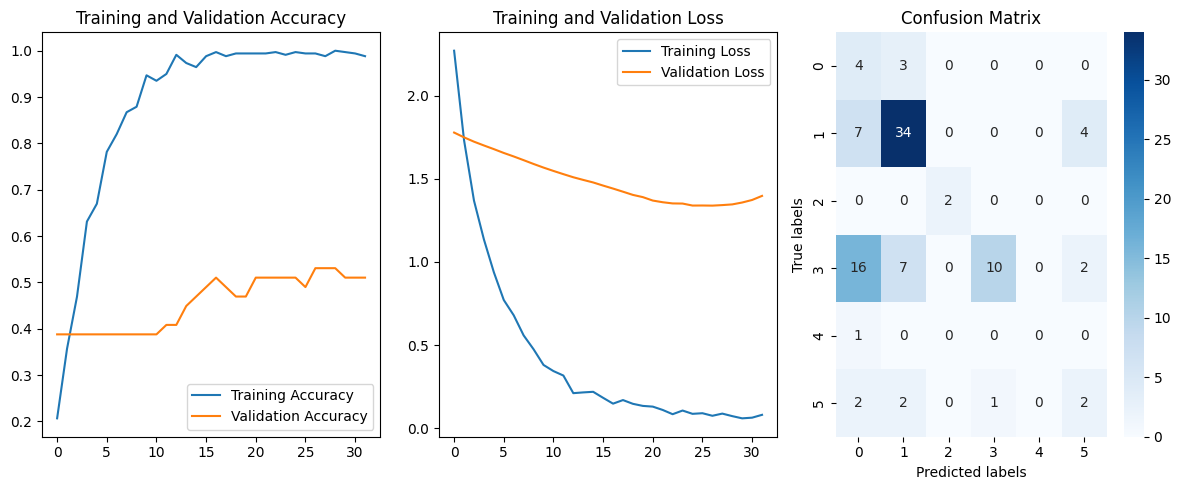

In [74]:
plot_graph(
    hist=hist5,
    model=model5,
    X_val_padded=X_test_tfidf,
    y_val=y_test,
    classes=classes
)